# Plotting fishing catches simulated by DBPM
**Author**: Denisse Fierro Arcos  
**Date**: 2025-02-06  

## Loading relevant libraries

In [1]:
import os
os.chdir('/g/data/vf71/la6889/dbpm_southern_ocean/scripts/')
from glob import glob
import xarray as xr
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as PathEffects
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from dask.distributed import Client

## Start a cluster for parallelisation

In [2]:
client = Client(threads_per_worker = 1, memory_limit = 0)

## Selecting run and DBPM resolution

In [94]:
model_res = '1deg'
# Can be either '_simask' or blank ('')
runs = ''#_simask'

## Loading sea ice extent, bathymetry and fishing catches

In [96]:
#Catches
catch_all = xr.open_zarr(
    os.path.join('../data', f'mean_catch_all_regions{runs}_{model_res}_1961-2010.zarr'))
#Catches - monthly
catch_month_all = xr.open_zarr(
    os.path.join('../data', f'monthly_mean_catch_all_regions{runs}_{model_res}_1961-2010.zarr'))
#Exploitable biomass
tot_exp_all = xr.open_zarr(
    os.path.join('../data', f'mean_tot-exp-bio_all_regions{runs}_{model_res}_1961-2010.zarr'))
#Sea ice extent
sie_all = xr.open_zarr(
    os.path.join('../data', f'mean_sea-ice-edge_all_regions_{model_res}_1961-2010.zarr'))
#Sea ice extent - monthly
sie_month_all = xr.open_zarr(
    os.path.join('../data', f'monthly_mean_sea-ice-edge_all_regions_{model_res}_1961-2010.zarr'))
#Bathymetry
bathy_all = xr.open_zarr(os.path.join('../data', f'depth_all_regions_{model_res}_fixed.zarr'))

## Plotting mean estimated fishing catches for modelling period (1961-2010)

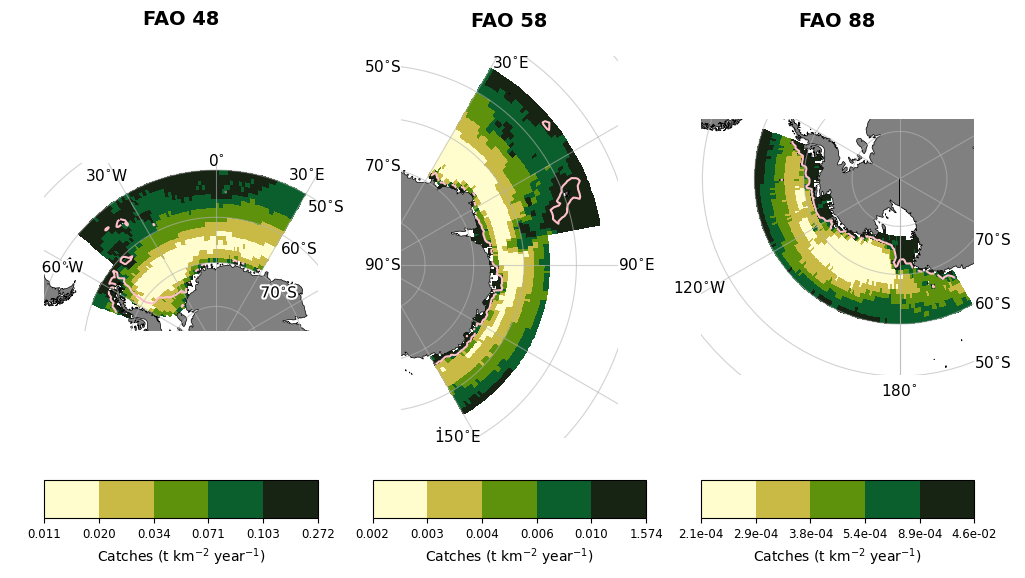

In [97]:
fig = plt.figure(figsize = (12, 6))

fao_reg = sorted(list(catch_all.keys()))
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black', 
                                   facecolor = 'gray', linewidth = 0.5)

gs = gridspec.GridSpec(nrows = 2, ncols = 3, height_ratios = (1, 0.1))

ax = {}
plots = {}
for i, r in enumerate(fao_reg):
    ax[i] = fig.add_subplot(gs[i], projection = ccrs.SouthPolarStereo())
    da = catch_all[r].where(catch_all[r] > 0)
    da_nocatch = catch_all[r].where(catch_all[r] == 0)
    levels = da.quantile(np.arange(0, 1.1, 0.2)).values
    plots[r] = da.plot(levels = levels, ax = ax[i], cmap = cm.cm.speed,
                       add_colorbar = False, transform = ccrs.PlateCarree())
    da_nocatch.plot.contourf(ax = ax[i], colors = ["#dfe4e4", "#3498db"], levels = [0, 1], 
                             add_colorbar = False, transform = ccrs.PlateCarree())
    bathy_all[r].plot.contour(ax = ax[i], levels = [1000], colors = 'pink', add_colorbar = False,
                          transform = ccrs.PlateCarree())
    ax[i].add_feature(land_50m)
    #Customise area shown in the maps
    coord_lab = 11
    if r == 'fao-48':
        ax[i].text(0.5, 1.85, r.replace('-', ' ').upper(), 
                   horizontalalignment = 'center', verticalalignment = 'center', 
                   transform = ax[i].transAxes, fontsize = 14, 
                   fontweight = 'bold')
        ax[i].set_extent([-65, 32.5, -80, -48], crs = ccrs.PlateCarree())
        plt.text(0.15, 0.89, '$30^{\circ}$W', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(-0.01, 0.35, '$60^{\circ}$W', transform = ax[i].transAxes, 
                 fontsize = coord_lab, 
                 path_effects = [PathEffects.withStroke(linewidth = 3, foreground = 'w')])
        plt.text(0.60, 0.98, '$0^{\circ}$', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.89, 0.9, '$30^{\circ}$E', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.79, 0.2, '$70^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab,
                 path_effects = [PathEffects.withStroke(linewidth = 3, foreground = 'w')])
        plt.text(0.86, 0.46, '$60^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.96, 0.71, '$50^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
    elif r == 'fao-58':
        ax[i].text(0.5, 1.09, r.replace('-', ' ').upper(), 
                   horizontalalignment = 'center', verticalalignment = 'center', 
                   transform = ax[i].transAxes, fontsize = 14, 
                   fontweight = 'bold')
        ax[i].set_extent([30, 136, -80, -42.5], crs = ccrs.PlateCarree())
        plt.text(-0.17, 0.96, '$50^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(-0.17, 0.7, '$70^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(-0.17, 0.44, '$90^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.42, 0.97, '$30^{\circ}$E', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(1, 0.44, '$90^{\circ}$E', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.15, -0.01, '$150^{\circ}$E', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
    else:
        ax[i].text(0.5, 1.38, r.replace('-', ' ').upper(), 
                   horizontalalignment = 'center', verticalalignment = 'center', 
                   transform = ax[i].transAxes, fontsize = 14, 
                   fontweight = 'bold')
        ax[i].set_extent([158, 287.5, -80, -49.5], crs = ccrs.PlateCarree())
        plt.text(1, 0.51, '$70^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(1, 0.26, '$60^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(1, 0.03, '$50^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(-0.1, 0.32, '$120^{\circ}$W', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.66, -0.08, '$180^{\circ}$', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
    
    ax[i].set_title('')
        
    #Remove border around map
    [s.set_visible(False) for s in ax[i].spines.values()]
    gl = ax[i].gridlines(draw_labels = True, y_inline = False, 
                         color = "#b4b4b4", alpha = 0.6)
    # #Removing coordinate labels for latitude and longitude
    gl.xlabel_style = {'alpha': 0}
    gl.ylabel_style = {'alpha': 0}

cbar = fig.colorbar(plots['fao-48'], cax = plt.subplot(gs[3]), 
                    orientation = 'horizontal', pad = 0.075, format = '%.3f')
cbar.set_label('Catches (t km$^{-2}$ year$^{-1}$)', y = .95)
cbar.ax.tick_params(labelsize = 8.5)
cbar = fig.colorbar(plots['fao-58'], cax = plt.subplot(gs[4]), 
                    orientation = 'horizontal', pad = 0.075)
cbar.ax.tick_params(labelsize = 8.5)
cbar.set_label('Catches (t km$^{-2}$ year$^{-1}$)', y = .95)
cbar = fig.colorbar(plots['fao-88'], cax = plt.subplot(gs[5]), 
                    orientation = 'horizontal', pad = 0.075, format = '%4.1e')
cbar.set_label('Catches (t km$^{-2}$ year$^{-1}$)', y = .95)
cbar.ax.tick_params(labelsize = 8.5)

fout = os.path.join('../outputs', f'mean_catch_all_regions{runs}_{model_res}.png')
plt.savefig(fout, dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

## Plotting mean estimated exploitable biomass for modelling period (1961-2010)

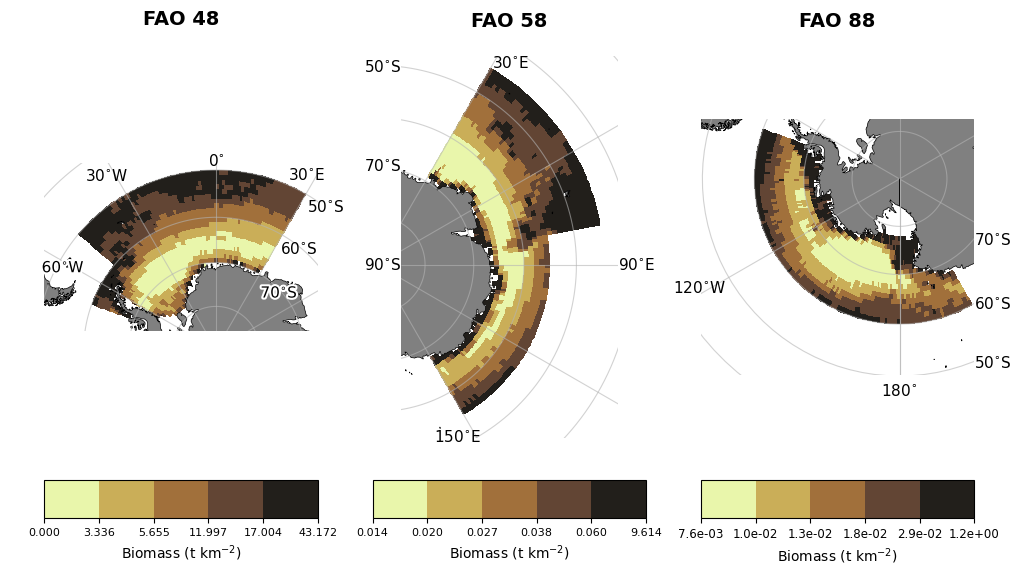

In [98]:
fig = plt.figure(figsize = (12, 6))

fao_reg = sorted(list(tot_exp_all.keys()))

gs = gridspec.GridSpec(nrows = 2, ncols = 3, height_ratios = (1, 0.1))

ax = {}
plots = {}
for i, r in enumerate(fao_reg):
    ax[i] = fig.add_subplot(gs[i], projection = ccrs.SouthPolarStereo())
    da = tot_exp_all[r]
    levels = da.quantile(np.arange(0, 1.1, 0.2)).values
    plots[r] = da.plot(levels = levels, ax = ax[i], cmap = cm.cm.turbid,
                       add_colorbar = False, transform = ccrs.PlateCarree())
    ax[i].add_feature(land_50m)
    #Customise area shown in the maps
    coord_lab = 11
    if r == 'fao-48':
        ax[i].text(0.5, 1.85, r.replace('-', ' ').upper(), 
                   horizontalalignment = 'center', verticalalignment = 'center', 
                   transform = ax[i].transAxes, fontsize = 14, 
                   fontweight = 'bold')
        ax[i].set_extent([-65, 32.5, -80, -48], crs = ccrs.PlateCarree())
        plt.text(0.15, 0.89, '$30^{\circ}$W', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(-0.01, 0.35, '$60^{\circ}$W', transform = ax[i].transAxes, 
                 fontsize = coord_lab, 
                 path_effects = [PathEffects.withStroke(linewidth = 3, foreground = 'w')])
        plt.text(0.60, 0.98, '$0^{\circ}$', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.89, 0.9, '$30^{\circ}$E', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.79, 0.2, '$70^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab,
                 path_effects = [PathEffects.withStroke(linewidth = 3, foreground = 'w')])
        plt.text(0.86, 0.46, '$60^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.96, 0.71, '$50^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
    elif r == 'fao-58':
        ax[i].text(0.5, 1.09, r.replace('-', ' ').upper(), 
                   horizontalalignment = 'center', verticalalignment = 'center', 
                   transform = ax[i].transAxes, fontsize = 14, 
                   fontweight = 'bold')
        ax[i].set_extent([30, 136, -80, -42.5], crs = ccrs.PlateCarree())
        plt.text(-0.17, 0.96, '$50^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(-0.17, 0.7, '$70^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(-0.17, 0.44, '$90^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.42, 0.97, '$30^{\circ}$E', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(1, 0.44, '$90^{\circ}$E', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.15, -0.01, '$150^{\circ}$E', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
    else:
        ax[i].text(0.5, 1.38, r.replace('-', ' ').upper(), 
                   horizontalalignment = 'center', verticalalignment = 'center', 
                   transform = ax[i].transAxes, fontsize = 14, 
                   fontweight = 'bold')
        ax[i].set_extent([158, 287.5, -80, -49.5], crs = ccrs.PlateCarree())
        plt.text(1, 0.51, '$70^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(1, 0.26, '$60^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(1, 0.03, '$50^{\circ}$S', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(-0.1, 0.32, '$120^{\circ}$W', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
        plt.text(0.66, -0.08, '$180^{\circ}$', transform = ax[i].transAxes, 
                 fontsize = coord_lab)
    
    ax[i].set_title('')
        
    #Remove border around map
    [s.set_visible(False) for s in ax[i].spines.values()]
    gl = ax[i].gridlines(draw_labels = True, y_inline = False, 
                         color = "#b4b4b4", alpha = 0.6)
    # #Removing coordinate labels for latitude and longitude
    gl.xlabel_style = {'alpha': 0}
    gl.ylabel_style = {'alpha': 0}

cbar = fig.colorbar(plots['fao-48'], cax = plt.subplot(gs[3]), 
                    orientation = 'horizontal', pad = 0.075, format = '%.3f')
cbar.set_label('Biomass (t km$^{-2}$)', y = .95)
cbar.ax.tick_params(labelsize = 8)
cbar = fig.colorbar(plots['fao-58'], cax = plt.subplot(gs[4]), 
                    orientation = 'horizontal', pad = 0.075)
cbar.ax.tick_params(labelsize = 8)
cbar.set_label('Biomass (t km$^{-2}$)', y = .95)
cbar = fig.colorbar(plots['fao-88'], cax = plt.subplot(gs[5]), 
                    orientation = 'horizontal', pad = 0.075, format = '%4.1e')
cbar.set_label('Biomass (t km$^{-2}$)', y = .95)
cbar.ax.tick_params(labelsize = 8.5)

# fout = os.path.join('../outputs', f'mean_tot-exp-bio_all_regions{runs}_{model_res}.png')
# plt.savefig(fout, dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)

## Plotting monthly means for fishing catches

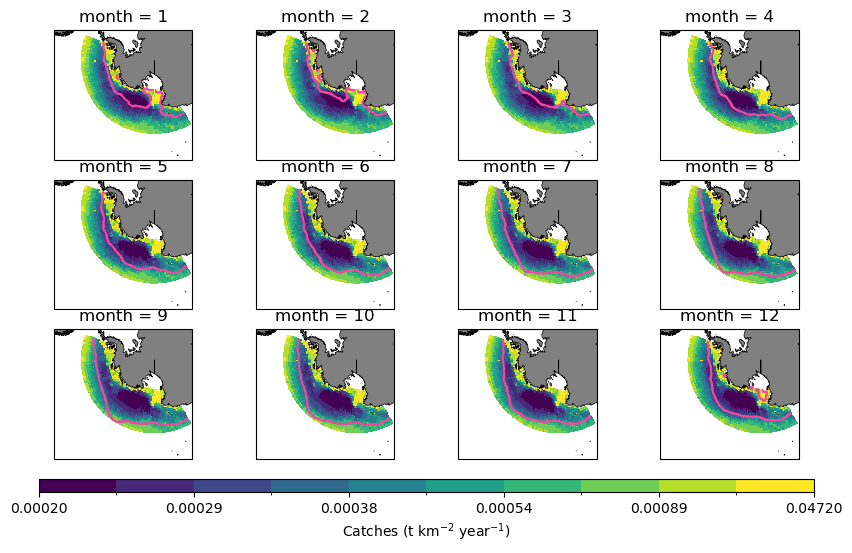

In [102]:
fig = plt.figure(figsize = (10, 6))
levels = catch_month_all['fao-88'].quantile(np.arange(0, 1.1, 0.1)).values
gs = gridspec.GridSpec(nrows = 4, ncols = 4, height_ratios = (1, 1, 1, 0.1))
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor = 'black',
                               facecolor = 'gray', linewidth = 0.5)

ax = {}
for i in range(12):
    ax[i] = fig.add_subplot(gs[i], projection = ccrs.SouthPolarStereo())
    p = catch_month_all['fao-88'].isel(month = i).plot(levels = levels, ax = ax[i], #cmap = cm.cm.speed,
                       add_colorbar = False, transform = ccrs.PlateCarree())
    sie_month.isel(month = i).plot.contour(levels = [0], ax = ax[i], colors = '#ef47a2',
                                           add_colorbar = False, transform = ccrs.PlateCarree())
    ax[i].add_feature(land_50m)
    ax[i].set_extent([158, 287.5, -80, -49.5], crs = ccrs.PlateCarree())

cbar = fig.colorbar(p, cax = plt.subplot(gs[-1,:]), 
                    orientation = 'horizontal')
cbar.set_label('Catches (t km$^{-2}$ year$^{-1}$)', y = .95)
fout = os.path.join('../outputs', f'mean_month_catch_{region}_{model_res}.png')
# plt.savefig(fout, dpi = 300, bbox_inches = 'tight', pad_inches = 0.05)